## Simple Linear Model vs Convolutional NN for MNIST digits classification

In this notebook we will compare the performance of two networks for classifying digits from MNIST dataset: first model is the simple fully connected linear model; the second one is convolutional NN. 

In [1]:
import os
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
%matplotlib inline

In [2]:
from pathlib import Path
import requests
import pickle
import gzip

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)


with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((X_train, y_train), (X_test, y_test), _) = pickle.load(f, encoding="latin-1")

9


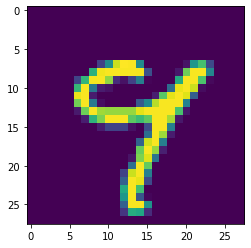

In [7]:
index = 54
plt.imshow(x_train[index].reshape((28, 28)))
print(y_train[index])

## Linear model

In [30]:
class Bobby(nn.Module):
    
    
    def __init__(self):
        super(Bobby, self).__init__()
        self.l1 = nn.Linear(784, 512)
        self.l2 = nn.Linear(512, 128)
        self.l3 = nn.Linear(128, 10)
        self.act_func = nn.ReLU()
    
    
    def forward(self, x):
        x = self.l1(x)
        x = self.act_func(x)
        x = self.l2(x)
        x = self.act_func(x)
        x = self.l3(x)
        return x
        
    
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Bobby().to(device)
print(model)
print(device)

Bobby(
  (l1): Linear(in_features=784, out_features=512, bias=True)
  (l2): Linear(in_features=512, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=10, bias=True)
  (act_func): ReLU()
)
cpu


loss  0 accuracy  1: 100%|█████████████████| 1000/1000 [00:07<00:00, 136.40it/s]


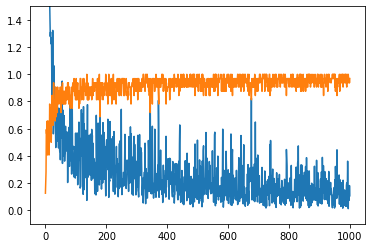

In [31]:
batch_size = 32
loss_func = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())
losses, accuracies = [], []
for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=batch_size)
    X = torch.tensor(X_train[samp].reshape((-1, 784))).float()
    y = torch.tensor(y_train[samp]).long()
    optim.zero_grad()
    out = model(X)
    preds = torch.argmax(out, dim=1)
    accuracy = (y == preds).float().mean()
    loss = loss_func(out, y)
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %2.f accuracy %2.f" % (loss, accuracy))

    
plt.ylim(-0.1, 1.5)
plt.plot(losses)
plt.plot(accuracies)

In [22]:
X_valid = torch.tensor(X_test.reshape(-1, 784)).float()
out = model(X_valid)

In [25]:
preds = torch.argmax(out, dim=1)

In [27]:
from sklearn.metrics import accuracy_score

In [28]:
print(accuracy_score(y_test, preds))

0.96


Alright, not bad, Linear Bobby. Let's see how the second model will do

## Convolutional model

In [6]:
import torch.nn.functional as F 

In [30]:
class ConvBobby(nn.Module):
    
    def __init__(self):
        super(ConvBobby, self).__init__()
        
        #first conv layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5, 5), stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        
        #second conv layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))
        
        #fully connected linear layer
        self.linear1 = nn.Linear(in_features=32*7*7, out_features=10)
        self.output = nn.Softmax(dim=1)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        print(x.shape)
        
        x = x.view(x.size(0), -1)
#         x = torch.flatten(x, 1)
#         x = torch.flatten(x, 1)
        x = self.linear1(x)
        res = self.output(x)
        
        return res
    

device = "cuda" if torch.cuda.is_available() else "cpu"
model_conv = ConvBobby().to(device)
print(model_conv)
print(device)

ConvBobby(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=1568, out_features=10, bias=True)
  (output): Softmax(dim=1)
)
cpu


In [31]:
batch_size = 1
loss_func = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_conv.parameters())
new_losses, new_accuracies = [], []
for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=batch_size)
    X = torch.tensor(X_train[samp].reshape((-1, 28, 28))).float()
    y = torch.tensor(y_train[samp]).long()
    optim.zero_grad()
    out = model_conv(X)
    preds = torch.argmax(out, dim=1)
    accuracy = (y == preds).float().mean()
    loss = loss_func(out, y)
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    new_losses.append(loss)
    new_accuracies.append(accuracy)
    t.set_description("loss %2.f accuracy %2.f" % (loss, accuracy))

    
plt.ylim(-0.1, 1.5)
plt.plot(losses)
plt.plot(accuracies)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

torch.Size([32, 7, 7])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x49 and 1568x10)